## Table of Contents


The table of contents for this project is as follows:-

1. [The problem statement](#1)
1. [Import libraries](#2)
1. [Import dataset](#3)
1. [Exploratory data analysis](#4)
    -    [View dimensions of dataset](#4.1)
    -    [Preview the dataset](#4.2)
    -    [View column names](#4.3)
    -    [View summary of dataset](#4.4)
    -    [View statistical properties of dataset](#4.5)
    -    [View frequency distribution of `PRECTOT_TOMORROW` variable](#4.6)
1.    [Heat Map](#5)
1.    [Pair Plot](#6)
1.    [Declare feature vector and target variable](#7)
1.    [Split data into separate training and test set](#8)
1.    [Handling missing values](#9)
1.    [Feature Scaling](#10)
1.    [Model Training](#11)
1.    [Check accuracy score](#12)
1.    [Regularization Parametere Optimization](#13)
1.    [Plotting test and train accuracy over regularization parameter](#14)
1.    [Calculating Mean Squared Error for test and train sets](#15)

## 1.The problem statement <a class="anchor" id="1"></a>

In meteorology, [**precipitation**](https://en.wikipedia.org/wiki/Precipitation) is any product of the condensation of atmospheric water vapor that falls under gravitational pull from clouds.
In this project, our aim is to answer the question whether [Hacettepe University Beytepe Campus](https://goo.gl/maps/LaJjnMUjHYFWF6ge9) will have precipitation tommorow.

We took the dataset from https://power.larc.nasa.gov/data-access-viewer/, which is publicly available.

We will solve this problem using Logistic Regression based model from SklitLearn and use Pandas, Numpy for array & dataframe operations. We also did some fine-tuning to increase accuracy such as choosing a suitable normalization parameter ( C ).

## 2. Import libraries <a class="anchor" id="2"></a>

In [1]:
# importing necessary modules

import pandas as pd # data processing, CSV file I/O
import numpy as np # linear algebra

# libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the './dataset' directory
import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

dataset\csv1.csv
dataset\csv2.csv


## 3. Import dataset <a class="anchor" id="3"></a>

In [2]:
def merge_csv(path_to_csv1: str, path_to_csv2: str):
    data1 = pd.read_csv(path_to_csv1)
    data2 = pd.read_csv(path_to_csv2)

    # Union of columns
    columns = list(set(data1.columns | data2.columns))

    d = {col: data1[col] if col in data1.columns else data2[col] for col in columns}
    merged_data = pd.DataFrame(data=d)

    # Rearranging columns
    new_order = ['DY', 'MO', 'YEAR', 'LAT', 'LON']
    columns_list = merged_data.columns.tolist()
    for col_name in new_order:
        columns_list.remove(col_name)

    columns_list = new_order + columns_list
    merged_data = merged_data[columns_list]

    return merged_data

def organize_data(merged_data : pd.DataFrame):
    organized_data = merged_data.copy()
    # If data has KT (Insolation Clearness Index) column it must be converted to float
    if 'KT' in merged_data:
        # 'KT' column may have 2 different values that describes missing values. nan and -999.0
        organized_data['KT'] = organized_data['KT'].replace('               nan', '-999')
        organized_data['KT'] = organized_data['KT'].astype(float)


    # Value for missing model data cannot be computed or out of model availability range: -999.0
    # Replace these values to np.nan in order to use pre-defined functions effectively.
    organized_data.replace(-999.0, np.nan, inplace=True)

    return organized_data

In [3]:
df = organize_data(merge_csv("dataset\csv1.csv", "dataset\csv2.csv"))

## 4. Exploratory data analysis <a class="anchor" id="4"></a>
- We have imported the data

- Now, its time to explore the data to gain insights about it

### 4.1. View dimensions of dataset <a class="anchor" id="4.1"></a>

In [4]:
df.shape

(2223, 28)

### 4.2. Preview the dataset <a class="anchor" id="4.2"></a>

In [5]:
df.sample(n=5)

,DY,MO,YEAR,LAT,LON,T2M_MIN,TS,RH2M,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DWN,...,WS50M_RANGE,WS50M,WS10M_RANGE,T2M_MAX,WS10M_MAX,KT,PRECTOT,T2MWET,WS10M,PS
473,18,4,2016,39.75,32.75,8.71,15.76,41.60,6.98,6.95,...,3.52,1.56,2.21,24.17,2.57,0.70,0.00,3.43,1.11,90.26
1985,8,6,2020,39.75,32.75,14.36,23.36,34.89,8.46,8.35,...,3.88,3.44,3.69,31.60,4.68,0.72,0.00,6.54,2.55,89.25
785,24,2,2017,39.75,32.75,-2.12,4.11,65.80,4.61,4.60,...,4.54,6.53,3.41,13.93,6.22,0.72,0.00,-1.45,4.31,89.98
1833,8,1,2020,39.75,32.75,-3.58,-1.16,90.45,NaN,0.72,...,3.76,6.40,3.21,2.71,6.35,0.18,2.89,-2.23,4.43,89.43
605,28,8,2016,39.75,32.75,16.43,23.89,60.15,NaN,6.05,...,5.74,3.45,3.83,27.49,4.09,0.64,0.74,13.55,2.32,89.77


### 4.3. View column names <a class="anchor" id="4.3"></a>

In [6]:
df.columns

Index(['DY', 'MO', 'YEAR', 'LAT', 'LON', 'T2M_MIN', 'TS', 'RH2M',
       'CLRSKY_SFC_SW_DWN', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_LW_DWN', 'T2M',
       'T2M_RANGE', 'T2MDEW', 'QV2M', 'WS50M_MIN', 'WS50M_MAX', 'WS10M_MIN',
       'WS50M_RANGE', 'WS50M', 'WS10M_RANGE', 'T2M_MAX', 'WS10M_MAX', 'KT',
       'PRECTOT', 'T2MWET', 'WS10M', 'PS'],
      dtype='object')

### 4.4. View summary of dataset <a class="anchor" id="4.4"></a>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223 entries, 0 to 2222
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DY                 2223 non-null   int64  
 1   MO                 2223 non-null   int64  
 2   YEAR               2223 non-null   int64  
 3   LAT                2223 non-null   float64
 4   LON                2223 non-null   float64
 5   T2M_MIN            2223 non-null   float64
 6   TS                 2223 non-null   float64
 7   RH2M               2223 non-null   float64
 8   CLRSKY_SFC_SW_DWN  892 non-null    float64
 9   ALLSKY_SFC_SW_DWN  2215 non-null   float64
 10  ALLSKY_SFC_LW_DWN  2221 non-null   float64
 11  T2M                2223 non-null   float64
 12  T2M_RANGE          2223 non-null   float64
 13  T2MDEW             2223 non-null   float64
 14  QV2M               2223 non-null   float64
 15  WS50M_MIN          2223 non-null   float64
 16  WS50M_MAX          2223 

#### Comment
- We can see that the dataset only contains numerical variables.
- Numerical have 2 different variable types 'int64' and 'float64'
- Also, there are some missing values in the dataset. We will explore it later.

### 4.5. View statistical properties of dataset <a class="anchor" id="4.5"></a>

In [8]:
df.describe()

,DY,MO,YEAR,LAT,LON,T2M_MIN,TS,RH2M,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DWN,...,WS50M_RANGE,WS50M,WS10M_RANGE,T2M_MAX,WS10M_MAX,KT,PRECTOT,T2MWET,WS10M,PS
count,2223.000000,2223.000000,2223.000000,2223.00,2223.00,2223.000000,2223.000000,2223.000000,892.000000,2215.000000,...,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2213.000000,2223.000000,2223.000000,2223.000000,2223.000000
mean,15.736392,6.444894,2017.549258,39.75,32.75,5.531948,11.872236,61.681957,5.861670,4.601842,...,4.280571,4.474215,3.253981,18.013536,4.861188,0.565522,1.135146,3.433315,3.151988,89.672785
std,8.805415,3.486311,1.745556,0.00,0.00,7.881937,10.079966,18.028254,1.947353,2.259129,...,1.738452,1.725476,1.432924,10.239055,1.877021,0.162429,2.635750,5.895196,1.240530,0.453013
min,1.000000,1.000000,2015.000000,39.75,32.75,-17.460000,-14.640000,14.050000,2.490000,0.270000,...,0.690000,0.780000,0.720000,-7.090000,1.220000,0.070000,0.000000,-14.390000,0.640000,87.790000
25%,8.000000,3.000000,2016.000000,39.75,32.75,-1.020000,3.150000,47.410000,4.000000,2.655000,...,2.980000,3.245000,2.270000,9.470000,3.490000,0.470000,0.000000,-0.865000,2.280000,89.400000
50%,16.000000,6.000000,2018.000000,39.75,32.75,5.280000,11.430000,61.770000,6.220000,4.490000,...,4.060000,4.240000,3.020000,18.300000,4.570000,0.640000,0.030000,3.480000,2.950000,89.670000
75%,23.000000,9.000000,2019.000000,39.75,32.75,12.620000,20.945000,75.765000,7.660000,6.665000,...,5.310000,5.400000,3.905000,27.035000,5.820000,0.690000,0.800000,8.280000,3.780000,89.960000
max,31.000000,12.000000,2021.000000,39.75,32.75,21.900000,30.990000,100.000000,8.630000,8.630000,...,16.580000,14.290000,12.810000,37.990000,14.980000,0.750000,22.270000,16.200000,11.010000,91.220000


In [9]:
today_precipitation = (df['PRECTOT'] > 0).astype(int)
tomorrow_precipitation = [1 if x > 0 else 0 for x in today_precipitation]
tomorrow_precipitation.pop(0)
tomorrow_precipitation.append(1)

df['PRECTOT_TODAY'] = today_precipitation
df['PRECTOT_TOMORROW'] = np.array(tomorrow_precipitation)
df.drop(columns=['LAT', 'LON'], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223 entries, 0 to 2222
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DY                 2223 non-null   int64  
 1   MO                 2223 non-null   int64  
 2   YEAR               2223 non-null   int64  
 3   T2M_MIN            2223 non-null   float64
 4   TS                 2223 non-null   float64
 5   RH2M               2223 non-null   float64
 6   CLRSKY_SFC_SW_DWN  892 non-null    float64
 7   ALLSKY_SFC_SW_DWN  2215 non-null   float64
 8   ALLSKY_SFC_LW_DWN  2221 non-null   float64
 9   T2M                2223 non-null   float64
 10  T2M_RANGE          2223 non-null   float64
 11  T2MDEW             2223 non-null   float64
 12  QV2M               2223 non-null   float64
 13  WS50M_MIN          2223 non-null   float64
 14  WS50M_MAX          2223 non-null   float64
 15  WS10M_MIN          2223 non-null   float64
 16  WS50M_RANGE        2223 

### 4.6. View frequency distribution of `PRECTOT_TOMORROW` variable <a class="anchor" id="4.6"></a>

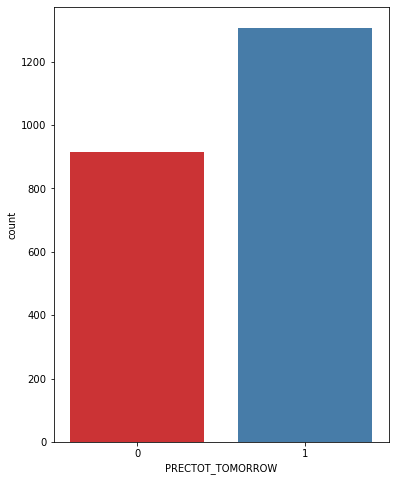

In [11]:
f, ax = plt.subplots(figsize=(6, 8))
ax = sns.countplot(x="PRECTOT_TOMORROW", data=df, palette="Set1")
plt.show()

#### Interpretation

- The above univariate plot confirms our findings that -

   - The `0` variable have 916 entries, and
   
   - The `1` variable have 1307 entries.



## 5. Heat Map <a class="anchor" id="5"></a>

In [12]:
correlation = df.iloc[:, 3:].corr()

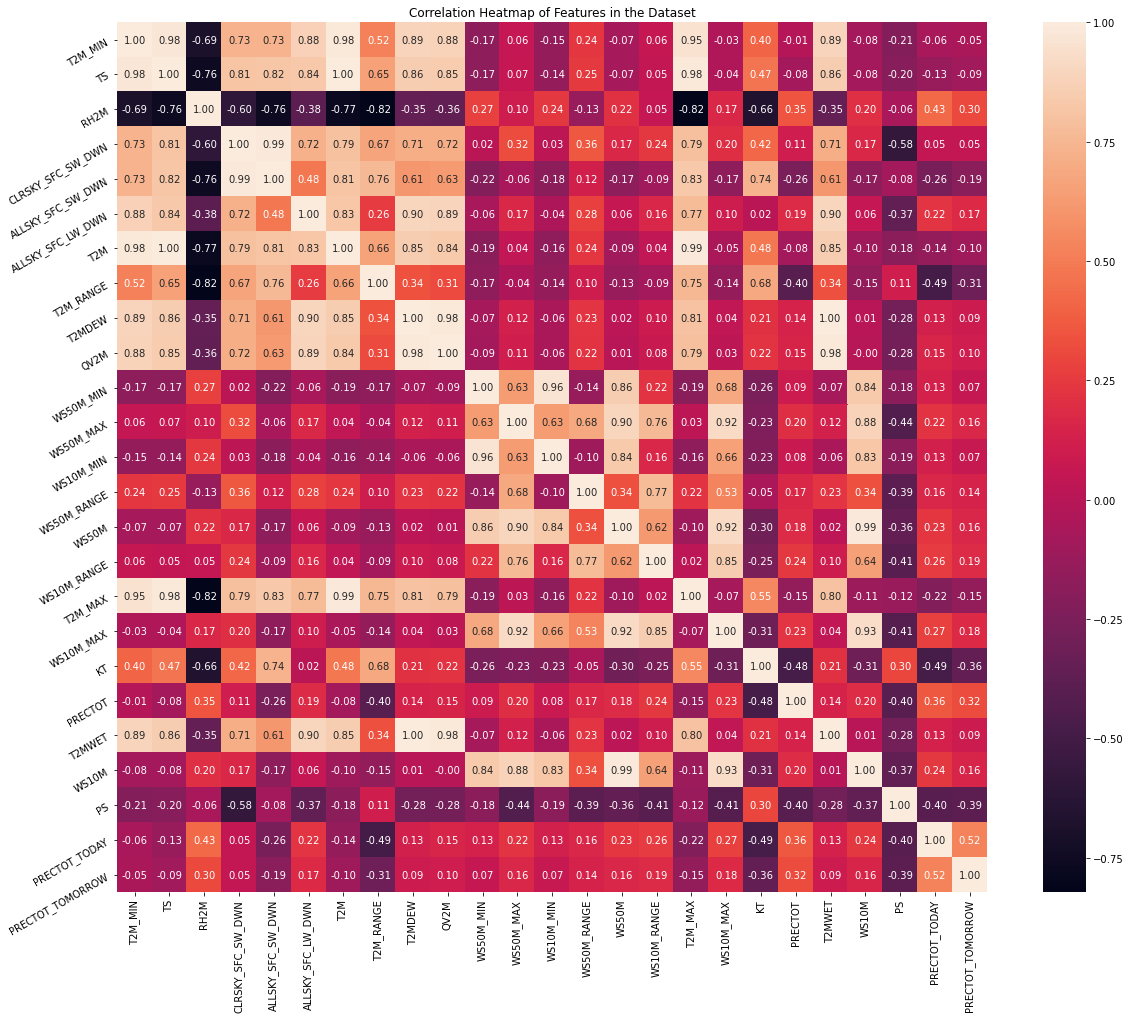

In [13]:
plt.figure(figsize=(20,16))
plt.title('Correlation Heatmap of Features in the Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

### Some significant results from correlation heat map
According to correlation heat map:
- `KT` (Insolation Clearness Index) and `PRECTOT` (Precipitation) has a negative correlation (-0.48).
- `RH2M` (Relative Humidity at 2 Meters) and `PRECTOT` (Precipitation) has a positive correlation (0.35).
- `WS10M_RANGE` (Wind Speed Range at 10 Meters) and `PRECTOT` (Precipitation) has a somewhat positive correlation (0.24)

## 6. Pair Plot <a class="anchor" id="6"></a>


First of all, we will define extract the variables which are highly positively correlated. 

In [14]:
pair_parameters = ['T2M_MIN', 'T2M', 'ALLSKY_SFC_LW_DWN', 'QV2M', 'T2M_MAX', 'WS50M_MAX', 'RH2M', 'WS10M_MIN', 'TS', 
                   'T2MDEW', 'T2M_RANGE', 'WS50M_MIN', 'WS10M_MAX', 'T2MWET', 'ALLSKY_SFC_SW_DWN', 'WS10M', 'PS', 
                   'CLRSKY_SFC_SW_DWN', 'PRECTOT_TOMORROW']

Now, we will draw pairplot to depict relationship between these variables.

In [ ]:
sns.pairplot(df[pair_parameters], kind='scatter', diag_kind='hist', palette='Rainbow')
plt.show()

## 7. Declare feature vector and target variable <a class="anchor" id="7"></a>

In [ ]:
#TODO check here
X = df.drop('PRECTOT_TOMORROW', axis=1)
y = df['PRECTOT_TOMORROW']

X.drop(columns=['DY', 'MO', 'YEAR'], inplace=True)

## 8. Split data into separate training and test set <a class="anchor" id="8"></a>

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into test and train sets.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## 9. Handling missing values <a class="anchor" id="9"></a>

In [ ]:
# impute missing values in X_train and X_test with respective column median in X_train

X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

In [ ]:
X_test.isna().sum()

## 10. Feature Scaling <a class="anchor" id="10"></a>

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[X.columns])
X_test = pd.DataFrame(X_test, columns=[X.columns])

## 11. Model Training <a class="anchor" id="11"></a>

In [ ]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# instantiate the model
logreg = LogisticRegression(solver='liblinear')

# fit the model
logreg.fit(X_train, y_train)

## 12. Check accuracy score <a class="anchor" id="12"></a>

In [ ]:
# print the scores on training and test set

print('Training set accuracy: {:.4f}'.format(logreg.score(X_train, y_train)))

# Compare the train-set and test-set accuracy
print('Test set accuracy: {:.4f}'.format(logreg.score(X_test, y_test)))
test_accuracy = logreg.score(X_test, y_test)

## 13. Regularization Parametere Optimization <a class="anchor" id="13"></a>

In [ ]:
max_accur, best_c_val = test_accuracy, 15
c_vals = np.linspace(1, 200, 2000)

test_accur_over_c = np.zeros(2000)
train_accur_over_c = np.zeros(2000)

for i in range(len(c_vals)):
    # fit the Logsitic Regression model with C=100
    # instantiate the model
    logreg = LogisticRegression(C=c_vals[i], solver='liblinear')

    # fit the model
    logreg.fit(X_train, y_train)
    
    test_accur = logreg.score(X_test, y_test)
    train_accur = logreg.score(X_train, y_train)
    
    test_accur_over_c[i] = test_accur
    train_accur_over_c[i] = train_accur
    
    if test_accur > max_accur:
        best_c_val = c_vals[i]
        max_accur = test_accur

print("Best accuracy we got {:.4f}, using {:.4f} as C value".format(max_accur, best_c_val))

## 14. Plotting test and train accuracy over regularization parameter <a class="anchor" id="14"></a>

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(c_vals, test_accur_over_c, label="test accuracy")
plt.plot(c_vals, train_accur_over_c, label="train accuracy")

plt.xlabel('c_vals')
plt.ylabel('accuracy')

plt.legend()

plt.grid()
plt.show()

## 15. Calculating Mean Squared Error for test and train sets <a class="anchor" id="15"></a>

In [ ]:
m = X_test.shape[0]

test_error_over_m = np.zeros(m)
train_error_over_m = np.zeros(m)

In [ ]:
from sklearn.metrics import mean_squared_error

for m_val in range(1, m):
    new_X_train = X_train[:m_val+1]
    new_y_train = y_train[:m_val+1]
    
    new_X_test = X_test[:m_val+1]
    new_y_test = y_test[:m_val+1]
    
    logreg = LogisticRegression(C=best_c_val, solver='liblinear', random_state=0)

    # fit the model
    logreg.fit(new_X_train, new_y_train)
    
    train_error_over_m[m_val] = mean_squared_error(new_y_train, logreg.predict(new_X_train))
    test_error_over_m[m_val] = mean_squared_error(new_y_test, logreg.predict(new_X_test))

### Plotting test and train error over set size

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(list(range(1, m + 1)), test_error_over_m, label="Test Error")
plt.plot(list(range(1, m + 1)), train_error_over_m, label="Train Error")

plt.xlabel('Set Size')
plt.ylabel('Mean Squared Error')

plt.legend()

plt.grid()
plt.show()